In [32]:
# Re-import needed modules after reset
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Load the JSON data from file
file_path = Path("url_data2.json")
with open(file_path, "r") as f:
    data = json.load(f)

# Recreate enhanced compliance records
enhanced_compliance_records = []

def is_not_nully(value):
    return value is not None and value != "" and value!= "None" and value != "N/A"

ctr = 0
for domain, details in data.items():
    external = details.get("external_buttons", {})
    internal = details.get("internal_buttons", [])

    internal_keys = {btn.get("option_name") for btn in internal if "option_name" in btn}
    ctr_prev = ctr
    if "reject_all" in external and "accept_all" in external:
        button_reject = external["reject_all"]
        button_accept = external["accept_all"]
        for k in ["id", "text"]:
            if button_reject.get(k) == button_accept.get(k) and is_not_nully(button_reject.get(k)):
                ctr += 1
                print("{}. button has same {} for accept and reject in website {}, which is {}".format(ctr, k, domain, button_reject.get(k)))
                external.pop("reject_all")
                break
    
    has_reject_all_external = "reject_all" in external
    has_reject_all_internal = "reject_all" in internal_keys
    has_reject_all = has_reject_all_external or has_reject_all_internal

    domain_data = {
        "domain": domain,
        "has_reject_all": has_reject_all,
        "reject_all_location": (
            "external" if has_reject_all_external else
            "internal" if has_reject_all_internal else
            "none"
        ),
        "has_granular_prefs": "marketing" in internal_keys and "performance" in internal_keys,
        "has_manage_prefs": "manage_my_preferences" in external
    }

    enhanced_compliance_records.append(domain_data)

    if ctr > ctr_prev:
        print(domain_data)

# Question 1: Count dark patterns (reject_all in internal only)
dark_pattern_count = sum(
    entry["reject_all_location"] == "internal" for entry in enhanced_compliance_records
)
no_dark_pattern_count = sum(
    entry["reject_all_location"] == "external" for entry in enhanced_compliance_records
)

# Question 2: Presence of "reject all"
has_reject_all_count = sum(entry["has_reject_all"] for entry in enhanced_compliance_records)
no_reject_all_count = len(enhanced_compliance_records) - has_reject_all_count

# Question 3: Granular preferences
granular_count = sum(entry["has_granular_prefs"] for entry in enhanced_compliance_records)
no_granular_count = len(enhanced_compliance_records) - granular_count

# Question 4: Steps to opt out
step_counts = []
for entry in enhanced_compliance_records:
    if entry["reject_all_location"] == "external":
        step_counts.append(1)
    elif entry["reject_all_location"] == "internal":
        step_counts.append(2)
    elif entry["has_manage_prefs"] and not entry["has_reject_all"]:
        step_counts.append(3)


1. button has same id for accept and reject in website computerbase.de, which is cookie-consent-button
{'domain': 'computerbase.de', 'has_reject_all': False, 'reject_all_location': 'none', 'has_granular_prefs': False, 'has_manage_prefs': False}
2. button has same id for accept and reject in website gambleaware.org, which is standard.front_page
{'domain': 'gambleaware.org', 'has_reject_all': False, 'reject_all_location': 'none', 'has_granular_prefs': False, 'has_manage_prefs': False}
3. button has same id for accept and reject in website klook.com, which is cookie-agreement
{'domain': 'klook.com', 'has_reject_all': False, 'reject_all_location': 'none', 'has_granular_prefs': False, 'has_manage_prefs': False}
4. button has same id for accept and reject in website life.ru, which is personDataConsent
{'domain': 'life.ru', 'has_reject_all': False, 'reject_all_location': 'none', 'has_granular_prefs': False, 'has_manage_prefs': False}
5. button has same id for accept and reject in website mill

In [33]:
for entry in enhanced_compliance_records:
    if entry["reject_all_location"] == "internal":
        print(entry["domain"])

3dsystems.com
accorhotels.com
acer.com
agilent.com
aicpa.org
bismarcktribune.com
bitnami.com
blog4ever.com
businesswire.com
canneslions.com
chicagobooth.edu
nature.com
schneider-electric.com
ssrn.com


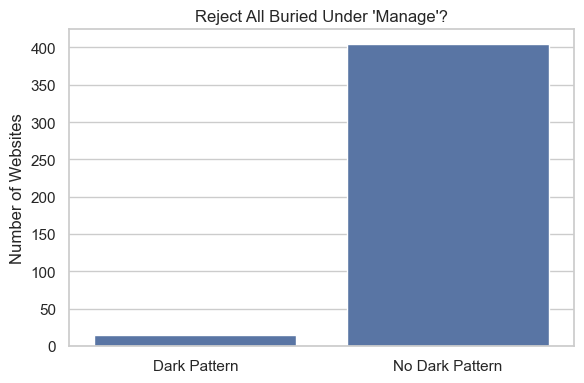

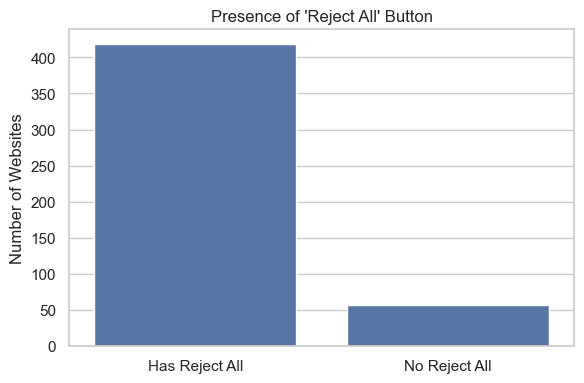

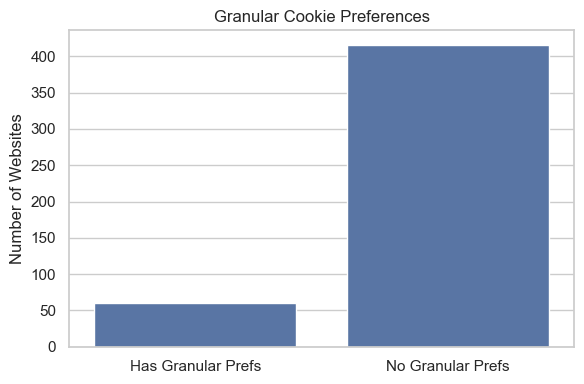

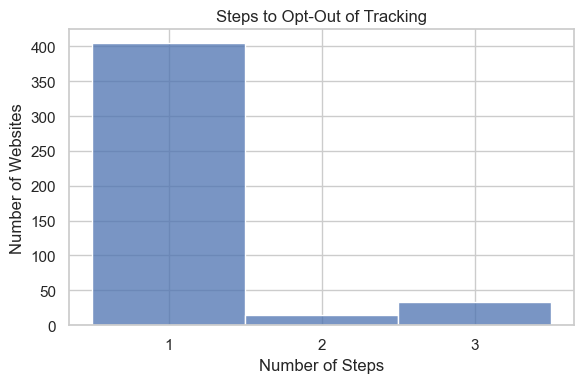

In [34]:
# Plot 1: Dark patterns
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.barplot(x=["Dark Pattern", "No Dark Pattern"], y=[dark_pattern_count, no_dark_pattern_count])
plt.title("Reject All Buried Under 'Manage'?")
plt.ylabel("Number of Websites")
plt.tight_layout()
plt.show()

# Plot 2: Reject All presence
plt.figure(figsize=(6, 4))
sns.barplot(x=["Has Reject All", "No Reject All"], y=[has_reject_all_count, no_reject_all_count])
plt.title("Presence of 'Reject All' Button")
plt.ylabel("Number of Websites")
plt.tight_layout()
plt.show()

# Plot 3: Granular Preferences
plt.figure(figsize=(6, 4))
sns.barplot(x=["Has Granular Prefs", "No Granular Prefs"], y=[granular_count, no_granular_count])
plt.title("Granular Cookie Preferences")
plt.ylabel("Number of Websites")
plt.tight_layout()
plt.show()

# Plot 4: Steps to Opt Out
plt.figure(figsize=(6, 4))
sns.histplot(step_counts, bins=[1, 2, 3, 4], discrete=True)
plt.title("Steps to Opt-Out of Tracking")
plt.xlabel("Number of Steps")
plt.ylabel("Number of Websites")
plt.xticks([1, 2, 3])
plt.tight_layout()
plt.show()